In [84]:
import pandas as pd
import numpy as np

In [85]:
df = pd.read_excel(r'Online Retail.xlsx', sheet_name='Online Retail')

In [86]:
df.head() # Check for NaN values in 'UnitPrice'

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [87]:
df[(df['Quantity'] < 0) & (df['InvoiceNo'].isna() )]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


# Chuẩn bị dữ liệu

## Country Table

In [88]:
dim_country = df['Country'].drop_duplicates().reset_index(drop=True)
dim_country = dim_country.dropna()

In [89]:
dim_country.duplicated().sum()
dim_country.isnull().sum()

0

In [90]:
dim_country = dim_country.to_csv('dim_country.csv', index=False)

## Product Table

In [91]:
dim_product = df[['Description', 'StockCode']]
dim_product.head()

,Description,StockCode
0,WHITE HANGING HEART T-LIGHT HOLDER,85123A
1,WHITE METAL LANTERN,71053
2,CREAM CUPID HEARTS COAT HANGER,84406B
3,KNITTED UNION FLAG HOT WATER BOTTLE,84029G
4,RED WOOLLY HOTTIE WHITE HEART.,84029E


In [92]:
dim_product['StockCode'] = dim_product['StockCode'].astype(str).str.strip().str.upper()
dim_product['Description'] = dim_product['Description'].astype(str).str.strip().str.upper()


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_20192\87890445.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dim_product['StockCode'] = dim_product['StockCode'].astype(str).str.strip().str.upper()
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_20192\87890445.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dim_product['Description'] = dim_product['Description'].astype(str).str.strip().str.upper()


In [93]:
dim_product = dim_product.drop_duplicates('StockCode')

In [94]:
dim_product.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3958 entries, 0 to 540421
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Description  3958 non-null   object
 1   StockCode    3958 non-null   object
dtypes: object(2)
memory usage: 92.8+ KB


In [95]:
dim_product['Description'] = dim_product['Description'].astype(str).str.strip().str.upper()

In [96]:
def categorize_product(desc):
    if pd.isnull(desc):
        return "Unknown"
    desc = desc.lower()  # chuyển chữ thường để dễ dò từ khóa

    if any(keyword in desc for keyword in ["lantern", "light", "lamp", "frame", "candle", "mirror", "hanger"]):
        return "Trang trí & nội thất"
    elif any(keyword in desc for keyword in ["mug", "cup", "bowl", "plate", "coaster", "tray", "teapot"]):
        return "Nhà bếp & dụng cụ ăn uống"
    elif any(keyword in desc for keyword in ["heart", "box", "bag", "ribbon", "star", "bell", "flower"]):
        return "Đồ thủ công & trang trí"
    elif any(keyword in desc for keyword in ["christmas", "xmas", "tree", "snow", "bauble", "stocking"]):
        return "Giáng sinh / Lễ hội"
    elif any(keyword in desc for keyword in ["gift", "set", "keyring", "bookmark", "tin", "calendar"]):
        return "Quà tặng & đồ lưu niệm"
    elif any(keyword in desc for keyword in ["toy", "child", "pencil", "ball", "jigsaw", "animal"]):
        return "Trẻ em / Đồ chơi"
    elif any(keyword in desc for keyword in ["pen", "notebook", "eraser", "sharpener", "clip"]):
        return "Văn phòng phẩm"
    elif any(keyword in desc for keyword in ["scarf", "purse", "bracelet", "ring"]):
        return "Phụ kiện thời trang"
    else:
        return "Khác"


In [97]:
dim_product["Category"] = dim_product['Description'].apply(categorize_product)


In [98]:
dim_product.to_csv('dim_product.csv', index=False)

In [99]:
dim_product['StockCode'].duplicated().sum()

0

## Customer Table

In [219]:
from faker import Faker

In [299]:
dim_customer = df['CustomerID'].drop_duplicates().dropna().to_frame(name='CustomerID').reset_index(drop=True)

In [300]:
dim_customer.head()

,CustomerID
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0


In [301]:
fake = Faker()
Faker.seed(42)

In [302]:
dim_customer['Customer_Name'] = [fake.name() for _ in dim_customer.index]

In [303]:
dim_customer.head()

,CustomerID,Customer_Name
0,17850.0,Allison Hill
1,13047.0,Noah Rhodes
2,12583.0,Angie Henderson
3,13748.0,Daniel Wagner
4,15100.0,Cristian Santos


In [254]:
dim_customer.to_csv('dim_customer.csv', index=False)

## Fact table - Orders.Header

In [226]:
## lấy các cột cần thiết từ df để tạo fact_orders_header
fact_orders_header = df[['InvoiceNo', 'Quantity', 'InvoiceDate','StockCode', 'UnitPrice', 'CustomerID', 'Country']]


In [227]:
## chuẩn hóa dữ liệu
fact_orders_header['StockCode'] = fact_orders_header['StockCode'].astype(str).str.strip().str.upper()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_20192\1497768659.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fact_orders_header['StockCode'] = fact_orders_header['StockCode'].astype(str).str.strip().str.upper()


In [228]:
## tạo các cột tính toán Revenue, COGs, và Gross Profit
fact_orders_header['Revenue'] = fact_orders_header['Quantity'] * fact_orders_header['UnitPrice']

In [229]:
## duplicate InvoiceDate to InvoiceDate_converted and normalize it
fact_orders_header['InvoiceDate_converted'] = pd.to_datetime(fact_orders_header['InvoiceDate']).dt.normalize()

In [230]:

result = fact_orders_header.groupby(['InvoiceNo']).agg({'Revenue': 'sum', 'Quantity': 'sum','InvoiceDate':'first','InvoiceDate_converted':'first', 'CustomerID': 'first', 'Country': 'first'}).reset_index()

In [231]:
result['InvoiceNo'] = result['InvoiceNo'].astype('string').str.strip().str.upper()

In [232]:
result

,InvoiceNo,Revenue,Quantity,InvoiceDate,InvoiceDate_converted,CustomerID,Country
0,536365,139.12,40,2010-12-01 08:26:00,2010-12-01,17850.0,United Kingdom
1,536366,22.20,12,2010-12-01 08:28:00,2010-12-01,17850.0,United Kingdom
2,536367,278.73,83,2010-12-01 08:34:00,2010-12-01,13047.0,United Kingdom
3,536368,70.05,15,2010-12-01 08:34:00,2010-12-01,13047.0,United Kingdom
4,536369,17.85,3,2010-12-01 08:35:00,2010-12-01,13047.0,United Kingdom
...,...,...,...,...,...,...,...
25895,C581484,-168469.60,-80995,2011-12-09 09:27:00,2011-12-09,16446.0,United Kingdom
25896,C581490,-32.53,-23,2011-12-09 09:57:00,2011-12-09,14397.0,United Kingdom
25897,C581499,-224.69,-1,2011-12-09 10:28:00,2011-12-09,15498.0,United Kingdom
25898,C581568,-54.75,-5,2011-12-09 11:57:00,2011-12-09,15311.0,United Kingdom


In [233]:
result.to_csv('fact_orders_header.csv', index=False)

## Fact table - OrderDetail

In [234]:
## Lấy các cột cần thiết từ df để tạo Fact_Order_Detail
Fact_Order_Detail = df[['InvoiceNo', 'StockCode', 'Quantity', 'UnitPrice']]

In [235]:
## chuẩn hóa dữ liệu
Fact_Order_Detail['StockCode'] = Fact_Order_Detail['StockCode'].astype(str).str.strip().str.upper()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_20192\1392264370.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Fact_Order_Detail['StockCode'] = Fact_Order_Detail['StockCode'].astype(str).str.strip().str.upper()


In [236]:
Fact_Order_Detail['Line Total'] = (Fact_Order_Detail['Quantity'] * Fact_Order_Detail['UnitPrice']).round(2)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_20192\1877250969.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Fact_Order_Detail['Line Total'] = (Fact_Order_Detail['Quantity'] * Fact_Order_Detail['UnitPrice']).round(2)


In [237]:
Fact_Order_Detail[Fact_Order_Detail['StockCode'].isna()]

,InvoiceNo,StockCode,Quantity,UnitPrice,Line Total


In [238]:
Fact_Order_Detail['Order Detail ID'] = np.arange(1, len(Fact_Order_Detail) + 1)
Fact_Order_Detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   InvoiceNo        541909 non-null  object 
 1   StockCode        541909 non-null  object 
 2   Quantity         541909 non-null  int64  
 3   UnitPrice        541909 non-null  float64
 4   Line Total       541909 non-null  float64
 5   Order Detail ID  541909 non-null  int32  
dtypes: float64(2), int32(1), int64(1), object(2)
memory usage: 22.7+ MB


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_20192\1188327817.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Fact_Order_Detail['Order Detail ID'] = np.arange(1, len(Fact_Order_Detail) + 1)


In [239]:
Fact_Order_Detail.to_csv('fact_order_detail.csv', index=False)

# Khai phá dữ liệu

In [280]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [304]:
result.head(10)

,InvoiceNo,Revenue,Quantity,InvoiceDate,InvoiceDate_converted,CustomerID,Country
0,536365,139.12,40,2010-12-01 08:26:00,2010-12-01,17850.0,United Kingdom
1,536366,22.20,12,2010-12-01 08:28:00,2010-12-01,17850.0,United Kingdom
2,536367,278.73,83,2010-12-01 08:34:00,2010-12-01,13047.0,United Kingdom
3,536368,70.05,15,2010-12-01 08:34:00,2010-12-01,13047.0,United Kingdom
4,536369,17.85,3,2010-12-01 08:35:00,2010-12-01,13047.0,United Kingdom
5,536370,855.86,449,2010-12-01 08:45:00,2010-12-01,12583.0,France
6,536371,204.00,80,2010-12-01 09:00:00,2010-12-01,13748.0,United Kingdom
7,536372,22.20,12,2010-12-01 09:01:00,2010-12-01,17850.0,United Kingdom
8,536373,259.86,88,2010-12-01 09:02:00,2010-12-01,17850.0,United Kingdom
9,536374,350.40,32,2010-12-01 09:09:00,2010-12-01,15100.0,United Kingdom


In [305]:
## df chứa thông tin RFM

df2 = result[['InvoiceNo', 'CustomerID', 'Revenue','Quantity', 'InvoiceDate_converted']].copy()

In [306]:
## Ngày tham chiếu để tính Recency
ref_date = pd.to_datetime(result['InvoiceDate_converted'].max())

In [307]:
## Tính toán các chỉ số RFM

df2_Groupby = df2.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',  # Frequency
    'Revenue': 'sum',  # Monetary
    'InvoiceDate_converted': lambda x: (ref_date - x.max()).days, # Recency
     'Quantity': 'sum' }).reset_index()


In [308]:
## đổi tên columns

df2_RFM = df2_Groupby.rename(columns={
    'InvoiceNo': 'Frequency',
    'Revenue': 'Monetary',
    'InvoiceDate_converted': 'Recency',
    'Quantity': 'Quantity',
    'CustomerID': 'CustomerID'})

In [310]:
df2_RFM.head()

,CustomerID,Frequency,Monetary,Recency,Quantity
0,12346.0,2,0.00,325,0
1,12347.0,7,4310.00,2,2458
2,12348.0,4,1797.24,75,2341
3,12349.0,1,1757.55,18,631
4,12350.0,1,334.40,310,197


In [311]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [312]:
X = df2_RFM[['Recency', 'Frequency', 'Monetary']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=18.
  warnings.warn(
c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=18.
  warnings.warn(
c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=18.
  warnings.warn(
c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Win

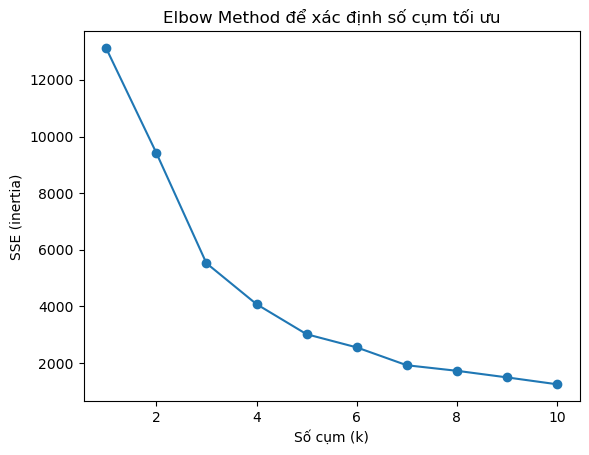

In [313]:
## xác định số cụm tối ưu bằng phương pháp Elbow
sse = []  # Sum of Squared Errors
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.plot(K, sse, marker='o')
plt.xlabel('Số cụm (k)')
plt.ylabel('SSE (inertia)')
plt.title('Elbow Method để xác định số cụm tối ưu')
plt.show()

In [314]:
## fit mô hình KMeans với số cụm đã chọn
# Giả sử số cụm tối ưu là 4 (dựa trên biểu đồ Elbow)

kmeans = KMeans(n_clusters=4, random_state=42)
df2_RFM['Cluster'] = kmeans.fit_predict(X_scaled)


c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=18.
  warnings.warn(


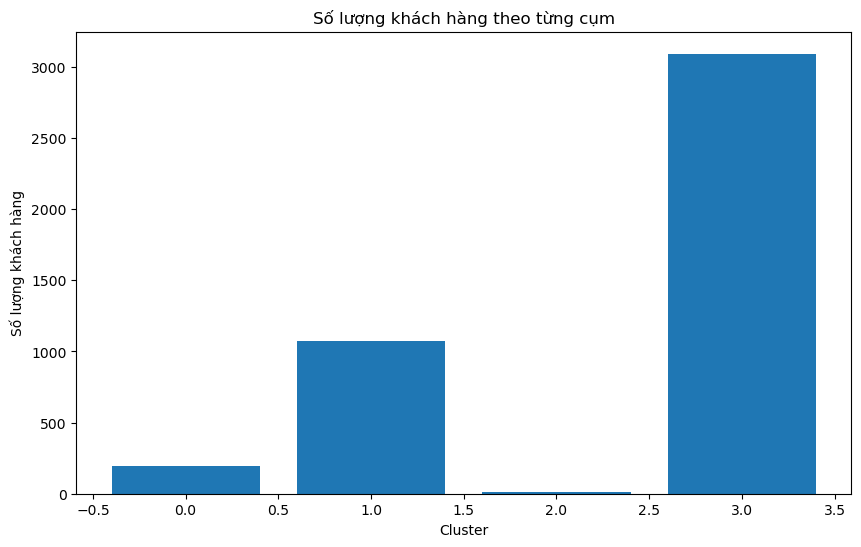

In [315]:
plt.figure(figsize=(10, 6))
plt.bar(df2_RFM['Cluster'].value_counts().index, df2_RFM['Cluster'].value_counts().values)
plt.xlabel('Cluster') 
plt.ylabel('Số lượng khách hàng')
plt.title('Số lượng khách hàng theo từng cụm')
plt.xticks(rotation=0)
plt.show() 

In [316]:
## gán tên cụm cho từng khách hàng
cluster_labels = {
    0: 'Loyal Customers',
    1: 'Inactive / Low Value',
    2: 'Top Tier Customers',  ## monetay cao nhất, fre 50-200, recency rất gần
    3: 'At Risk' ## monetary ~ cụm 0, fre thấp hơn cụm 0, recency > cụm 0, biên độ rộng
}

df2_RFM['Segment'] = df2_RFM['Cluster'].map(cluster_labels)


In [317]:
df2_RFM.head()

,CustomerID,Frequency,Monetary,Recency,Quantity,Cluster,Segment
0,12346.0,2,0.00,325,0,1,Inactive / Low Value
1,12347.0,7,4310.00,2,2458,3,At Risk
2,12348.0,4,1797.24,75,2341,3,At Risk
3,12349.0,1,1757.55,18,631,3,At Risk
4,12350.0,1,334.40,310,197,1,Inactive / Low Value


In [319]:
## merge với dim_customer để có thông tin khách hàng

dim_customer = dim_customer.merge(df2_RFM, on= 'CustomerID', how= 'left')
dim_customer.head()

,CustomerID,Customer_Name,Frequency,Monetary,Recency,Quantity,Cluster,Segment
0,17850.0,Allison Hill,35,5288.63,302,1693,0,Loyal Customers
1,13047.0,Noah Rhodes,18,3079.10,31,1355,3,At Risk
2,12583.0,Angie Henderson,18,7187.34,2,5009,0,Loyal Customers
3,13748.0,Daniel Wagner,5,948.25,95,439,3,At Risk
4,15100.0,Cristian Santos,6,635.10,330,58,1,Inactive / Low Value


In [322]:
dim_customer.to_csv('dim_customer.csv', index=False)